In [6]:
%matplotlib widget

from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
from dataclasses import dataclass

from typing import Callable, Tuple


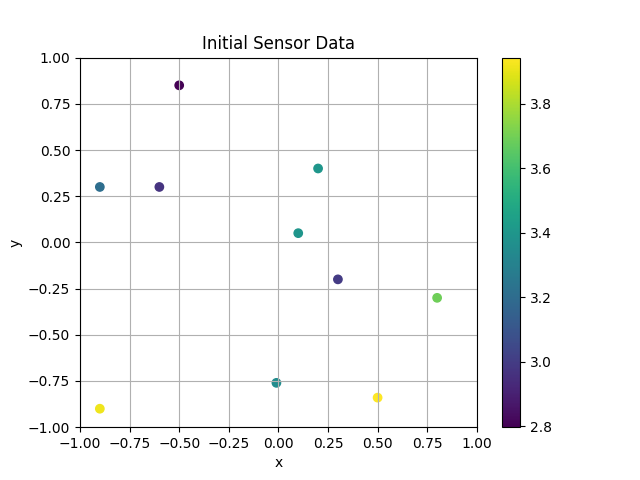

In [7]:
# Table 1: Initial Sensor Data
xdata = np.array([
    [0.1, -0.9, 0.2, 0.8, -0.6, 0.3, 0.5, -0.5, -0.01, -0.9],
    [0.05, 0.3, 0.4, -0.3, 0.3, -0.2, -0.84, 0.85, -0.76, -0.9]
])
ydata = np.array([
    3.39382006,
    3.2073034,
    3.39965035,
    3.68810201,
    2.96941623,
    2.99495501,
    3.94274928,
    2.7968011,
    3.34929734,
    3.91296165,
])

# visualize the initial data with colors
plt.figure()
plt.scatter(xdata[0], xdata[1], c=ydata)
plt.xlabel('x')
plt.xlim(-1, 1)
plt.ylabel('y')
plt.ylim(-1, 1)
plt.title('Initial Sensor Data')
plt.colorbar()
plt.grid()
plt.show()

In [8]:
# helper functions to run GPR
def sqexp(x: np.ndarray, xp: np.ndarray, tau: np.ndarray = [1, 1], l: np.ndarray = [0.5, 0.5]) -> np.ndarray:
    """Squared exponential kernel (2 dimensional).

    Args:
        x: (2, N) array of multiple inputs in 2D
        xp: (2,) array of the input at which the function values are known for each dimension

    Returns:
        cov (N,) -- Covariance between each input at *x* and the function values at *x*
    """
    cov0 = tau[0]**2 * np.exp(-1/2 * (x[0] - xp[0])**2 / l[0]**2)
    cov1 = tau[1]**2 * np.exp(-1/2 * (x[1] - xp[1])**2 / l[1]**2)
    return cov0*cov1


def periodic(x: np.ndarray, xp: np.ndarray, tau: np.ndarray = [1, 1], l: np.ndarray = [1, 1], p: np.ndarray = [0.4, 0.4]) -> np.ndarray:
    """Periodic kernel."""
    cov0 = tau[0]**2 * np.exp(-2 * np.sin(np.pi * np.abs(x[0] - xp[0]) / p[0])**2 / l[0]**2)
    cov1 = tau[1]**2 * np.exp(-2 * np.sin(np.pi * np.abs(x[1] - xp[1]) / p[1])**2 / l[1]**2)
    return cov0*cov1


def poly(x: np.ndarray, xp: np.ndarray, c: np.ndarray = [1, 1], d: np.ndarray[int] = [3, 3]):
    """Polynomial kernel."""
    cov0 = (x[0] * xp[0] + c[0])**d[0]
    cov1 = (x[1] * xp[1] + c[1])**d[1]
    return cov0*cov1


kernel_options = {"Sq.Exp": sqexp, "Periodic": periodic, "Poly": poly}


def build_covariance(x: np.ndarray, xp: np.ndarray, kern: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> np.ndarray:
    """Build a covariance matrix.

    Args:
        x: (2,N) array of x-y inputs in 2D
        xp: (2,M) array of x-y inputs in 2D
        kern: a function mapping inputs to covariance

    Outputs:
        cov: (N, M) covariance matrix
    """
    out = np.zeros((x.shape[1], xp.shape[1]))
    for jj in range(xp.shape[1]):
        # a single x-y data point is stored as a column vector
        out[:, jj] = kern(x, xp[:, jj])
    return out


def gpr(xtrain: np.ndarray,
        ytrain: np.ndarray,
        xpred: np.ndarray,
        noise_var: np.ndarray,
        mean_func: Callable[[np.ndarray], np.ndarray],
        kernel: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
    """Gaussian process regression Algorithm.

    Inputs:

        xtrain: (N, ) training inputs
        ytrain: (N, ) training outputs
        xpred:  (M, ) locations at which to make predictions
        noise_var: (N, ) noise at every training output
        mean_func: function to compute the prior mean
        kernel: covariance kernel

    Returns:
        pred_mean: (M, ) predicted mean at prediction points
        pred_cov: (M, M) predicted covariance at the prediction points
    """
    cov = build_covariance(xtrain, xtrain, kernel)
    # u, s, v = np.linalg.svd(cov)
    # sqrtcov = np.dot(u, np.sqrt(np.diag(s)))

    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(cov + np.diag(noise_var))

    pred_vec = build_covariance(xpred, xtrain, kernel)
    pred_mean = mean_func(xpred) + np.dot(pred_vec, np.dot(invcov, ytrain - mean_func(xtrain)))

    pred_cov_pre = build_covariance(xpred, xpred, kernel)
    pred_cov_up = np.dot(pred_vec, np.dot(invcov, pred_vec.T))
    pred_cov = pred_cov_pre - pred_cov_up

    return pred_mean, pred_cov

def plot_prior()

In [33]:
# covariance kernels
# squared exponential kernel
tau = [1, 1]
l = [0.2, 0.2]
def kernel(x, xp): return kernel_options["Sq.Exp"](x, xp, tau=tau, l=l)


# periodic exponential kernel
# tau = [1, 1]
# l = [1, 1]
# p = [0.4, 0.4]
# def kernel(x, xp): return kernel_options["Periodic"](x, xp, tau=tau, l=l, p=p)


# polynomial kernel
# c = [1, 1]
# d = [3, 3]
# def kernel(x, xp): return kernel_options["Poly"](x, xp, c=c, d=d)


def meanf(x):
    # prior mean function, just use the mean of the data
    return np.mean(ydata) * np.ones((x.shape[1]))


# covariance of noise for each data point
noise_cov = 1e-2 * np.ones(xdata.shape[1])

NUM_POINTS = 100
xpred = np.zeros((2, NUM_POINTS*NUM_POINTS))
for i in range(NUM_POINTS):
    xpred[0, i*NUM_POINTS:(i+1)*NUM_POINTS] = np.linspace(-1, 1, NUM_POINTS)
    xpred[1, i*NUM_POINTS:(i+1)*NUM_POINTS] = np.linspace(-1, 1, NUM_POINTS)[i]


# build prior
prior_mean = meanf(xpred)
prior_cov = build_covariance(xpred, xpred, kernel)

# do inference
pred_mean, pred_cov = gpr(xdata, ydata, xpred, noise_cov, meanf, kernel)

ValueError: Contour levels must be increasing

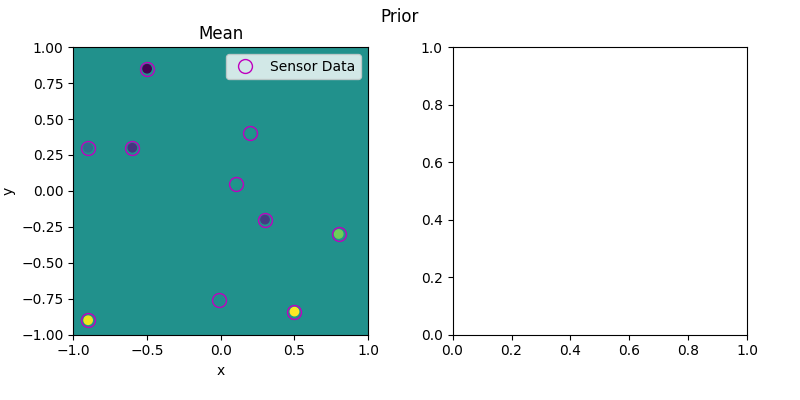

In [39]:
# prepare meshes for plotting contours
xpred_mesh_x, xpred_mesh_y = np.meshgrid(
    np.linspace(-1, 1, NUM_POINTS), np.linspace(-1, 1, NUM_POINTS))


prior_mean_mesh = prior_mean.reshape((NUM_POINTS, NUM_POINTS))
prior_std = np.sqrt(np.diag(prior_cov))
prior_std = prior_mean + 2*prior_std
prior_std_mesh = prior_std.reshape((NUM_POINTS, NUM_POINTS))
# use separate levels so easier to see
lmin_mean = min(np.min(prior_mean), np.min(ydata))
lmax_mean = max(np.max(prior_mean), np.max(ydata))
levels_mean = np.linspace(lmin_mean, lmax_mean, 100)
lmin_std = min(np.min(prior_std), np.min(prior_std))
lmax_std = max(np.max(prior_std), np.max(prior_std))
levels_std = np.linspace(lmin_std, lmax_std, 100)

# plot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.tight_layout(pad=3)
fig.suptitle('Prior')
# plot prior mean
ax[0].contourf(xpred_mesh_x, xpred_mesh_y, prior_mean_mesh, levels=levels_mean)
ax[0].scatter(xdata[0], xdata[1], c=ydata, vmin=lmin_mean, vmax=lmax_mean)
ax[0].plot(xdata[0], xdata[1], 'mo', markersize=10, fillstyle='none', label='Sensor Data')
ax[0].set_title('Mean')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].legend()
# plot prior std
ax[1].contourf(xpred_mesh_x, xpred_mesh_y, prior_std_mesh, levels=levels_std)
ax[1].plot(xdata[0], xdata[1], 'm.', markersize=2, label='Sensor Data')
ax[1].set_title(r'2$\sigma$')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].legend()
plt.show()

pred_mean_mesh = pred_mean.reshape((NUM_POINTS, NUM_POINTS))
pred_std = np.sqrt(np.diag(pred_cov))
pred_std = pred_mean + 2*pred_std
pred_std_mesh = pred_std.reshape((NUM_POINTS, NUM_POINTS))
# use separate levels so easier to see
lmin_mean = min(np.min(pred_mean), np.min(ydata))
lmax_mean = max(np.max(pred_mean), np.max(ydata))
levels_mean = np.linspace(lmin_mean, lmax_mean, 100)
lmin_std = min(np.min(pred_std), np.min(pred_std))
lmax_std = max(np.max(pred_std), np.max(pred_std))
levels_std = np.linspace(lmin_std, lmax_std, 100)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
fig.tight_layout(pad=3)
fig.suptitle('Posterior')
# plot posterior mean
ax[0].contourf(xpred_mesh_x, xpred_mesh_y, pred_mean_mesh, levels=levels_mean)
ax[0].scatter(xdata[0], xdata[1], c=ydata, vmin=lmin_mean, vmax=lmax_mean)
ax[0].plot(xdata[0], xdata[1], 'mo', markersize=10, fillstyle='none', label='Sensor Data')
ax[0].set_title('Mean')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].legend()
# plot posterior std
ax[1].contourf(xpred_mesh_x, xpred_mesh_y, pred_std_mesh, levels=levels_std)
ax[1].plot(xdata[0], xdata[1], 'm.', markersize=2, label='Sensor Data')
ax[1].set_title(r'2$\sigma$')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].legend()
plt.show()